# Action Recognition @ UCF101  
**Due date: 11:59 pm on Dec. 11, 2018 (Tuesday)**

## Description
---
In this homework, you will be doing action recognition using Recurrent Neural Network (RNN), (Long-Short Term Memory) LSTM in particular. You will be given a dataset called UCF101, which consists of 101 different actions/classes and for each action, there will be 145 samples. We tagged each sample into either training or testing. Each sample is supposed to be a short video, but we sampled 25 frames from each videos to reduce the data amount. Consequently, a training sample is a tuple of 3D volume with one dimension encoding *temporal correlation* between frames and a label indicating what action it is.

To tackle this problem, we aim to build a neural network that can not only capture spatial information of each frame but also temporal information between frames. Fortunately, you don't have to do this on your own. RNN — a type of neural network designed to deal with time-series data — is right here for you to use. In particular, you will be using LSTM for this task.

Instead of training a end-to-end neural network from scratch whose computation is prohibitively expensive for CPUs. We divide this into two steps: feature extraction and modelling. Below are the things you need to implement for this homework:
- **{35 pts} Feature extraction**. Use the pretrained VGG network to extract features from each frame. Specifically, we recommend  to use the activations of the first fully connected layer `torchvision.models.vgg16` (4096 dim) as features of each video frame. This will result into a 4096x25 matrix for each video. 
    **hints**: 
    - use `scipy.io.savemat()` to save feature to '.mat' file and `scipy.io.loadmat()` load feature.
    - norm your images using `torchvision.transforms`
    ```
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    prep = transforms.Compose([ transforms.ToTensor(), normalize ])
    prep(img)
    
    ```
    More detils of image preprocessing in PyTorch can be found at http://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    
- **{35 pts} Modelling**. With the extracted features, build an LSTM network which takes a 4096x25 sample as input, and outputs the action label of that sample.
- **{20 pts} Evaluation**. After training your network, you need to evaluate your model with the testing data by computing the prediction accuracy. Moreover, you need to compare the result of your network with that of support vector machine (SVM) (stacking the 4096x25 feature matrix to a long vector and train a SVM).
- **{10 pts} Report**. Details regarding the report can be found in the submission section below.

Notice that the size of the raw images is 256x340, whereas VGG16 takes 224x224 images as inputs. To solve this problem, instead of resizing the images which unfavorably changes the spatial ratio, we take a better solution: Cropping five 224x224 images at the image center and four corners and compute the 4096-dim VGG16 features for each of them, and average these five 4096-dim feature to get final feature representation for the raw image.

In order to save you computational time, we did the feature extraction of most samples for you except for class 1. For class 1, we provide you with the raw images, and you need to write code to extract the feature of the samples in class 1. Instead of training over the whole dataset on CPUs which mays cost you serval days, **use the first 15** classes of the whole dataset. The same applies to those who have access to GPUs.


## Dataset
Download dataset at [UCF101](http://vision.cs.stonybrook.edu/~yangwang/public/UCF101_dimitris_course.zip). 

The dataset is consist of the following two parts: video images and extracted features.

### 1. Video Images  

UCF101 dataset contains 101 actions and 13,320 videos in total.  

+ `annos/actions.txt`  
  + lists all the actions (`ApplyEyeMakeup`, .., `YoYo`)   
  
+ `annots/videos_labels_subsets.txt`  
  + lists all the videos (`v_000001`, .., `v_013320`)  
  + labels (`1`, .., `101`)  
  + subsets (`1` for train, `2` for test)  

+ `images_class1/`  
  + contains videos belonging to class 1 (`ApplyEyeMakeup`)  
  + each video folder contains 25 frames  


### 2. Video Features

+ `extract_vgg16_relu6.py`  
  + used to extract video features  
     + Given an image (size: 256x340), we get 5 crops (size: 224x224) at the image center and four corners. The `vgg16-relu6` features are extracted for all 5 crops and subsequently averaged to form a single feature vector (size: 4096).  
     + Given a video, we process its 25 images seuqentially. In the end, each video is represented as a feature sequence (size: 4096 x 25).  
  + written in PyTorch; supports both CPU and GPU.  

+ `vgg16_relu6/`  
   + contains all the video features, EXCEPT those belonging to class 1 (`ApplyEyeMakeup`)  
   + you need to run script `extract_vgg16_relu6.py` to complete the feature extracting process   


## Some Tutorials
- Good materials for understanding RNN and LSTM
    - http://blog.echen.me
    - http://karpathy.github.io/2015/05/21/rnn-effectiveness/
    - http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Implementing RNN and LSTM with PyTorch
    - [LSTM with PyTorch](http://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#sphx-glr-beginner-nlp-sequence-models-tutorial-py)
    - [RNN with PyTorch](http://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

In [1]:
# write your codes here
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as DD
import torchnet as tnt
from torch.autograd import Variable

import torchvision
from torchvision import datasets, models
from torchvision import transforms as T

import os
import cPickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import savemat, loadmat
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import LinearSVC

from PIL import Image
from glob import glob


In [0]:
################################
# load pretrained vgg16
# limit the classifier to first Dense
################################

#vgg = models.vgg16(pretrained=True)
#vgg_clr = list(vgg.classifier.children())
#new_clr = nn.Sequential(*([vgg_clr[0]]))
#vgg.classifier = new_clr
#print vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
################################
# Transforms for each class1 image
# 1. FiveCrop      2. ToTensor
# 3. Normalize     4. Stack
################################
#normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#prep = T.Compose([ T.ToTensor(), normalize ])

#transform = T.Compose([
#    T.FiveCrop((224,224)),
#    T.Lambda(lambda crops: torch.stack([prep(crop) for crop in crops])) 
#]) 

In [0]:
################################
# For each class1 video,
#    For each frame of this video,
#      Transform the image using above 
#      For each 5 cropped image,
#         extract vgg16 features
#      take mean of these 5 
#      for each frame, append feat to list
# savemat for each video
################################
# folder names for class1 videos
#c1_vid_folders = glob('../UCF101_release/images_class1/*')
#output_folder = '../UCF101_release/c1b_vgg16_relu6/'
#for vid in c1_vid_folders:
#    frames = glob(vid+'/*.jpg')
#    vgg_all = []
#    for img_name in frames:
#        print img_name
#        img = Image.open(img_name)
#        img_crops = transform(img)
#        ncrops, c, h, w = img_crops.size()
#        five_cropped_img_features = []
#        for cropped_img in img_crops:
#            feat_i = vgg(cropped_img.unsqueeze(0))
#            five_cropped_img_features.append(feat_i)
#        five = torch.stack(five_cropped_img_features)
#        mean_of_five_crops = five.mean(0).data
#        vgg_all.append(mean_of_five_crops)
#    vgg_for_vid = torch.stack(vgg_all)
#    dic = {}
#    fe=vgg_for_vid.numpy()
#    fe=fe.reshape((25, 4096))
#    dic['Feature'] = fe
#    print vid, fe.shape , '==========================='
#    savemat(output_folder+vid.split('/')[-1]+'.mat', dic)

../UCF101_release/images_class1/v_000105/i_0019.jpg
../UCF101_release/images_class1/v_000105/i_0022.jpg
../UCF101_release/images_class1/v_000105/i_0003.jpg
../UCF101_release/images_class1/v_000105/i_0014.jpg
../UCF101_release/images_class1/v_000105/i_0013.jpg
../UCF101_release/images_class1/v_000105/i_0017.jpg
../UCF101_release/images_class1/v_000105/i_0012.jpg
../UCF101_release/images_class1/v_000105/i_0007.jpg
../UCF101_release/images_class1/v_000105/i_0010.jpg
../UCF101_release/images_class1/v_000105/i_0021.jpg
../UCF101_release/images_class1/v_000105/i_0001.jpg
../UCF101_release/images_class1/v_000105/i_0016.jpg
../UCF101_release/images_class1/v_000105/i_0011.jpg
../UCF101_release/images_class1/v_000105/i_0002.jpg
../UCF101_release/images_class1/v_000105/i_0008.jpg
../UCF101_release/images_class1/v_000105/i_0015.jpg
../UCF101_release/images_class1/v_000105/i_0004.jpg
../UCF101_release/images_class1/v_000105/i_0025.jpg
../UCF101_release/images_class1/v_000105/i_0018.jpg
../UCF101_re

../UCF101_release/images_class1/v_000037 (25, 4096) ===========================
../UCF101_release/images_class1/v_000083/i_0019.jpg
../UCF101_release/images_class1/v_000083/i_0022.jpg
../UCF101_release/images_class1/v_000083/i_0003.jpg
../UCF101_release/images_class1/v_000083/i_0014.jpg
../UCF101_release/images_class1/v_000083/i_0013.jpg
../UCF101_release/images_class1/v_000083/i_0017.jpg
../UCF101_release/images_class1/v_000083/i_0012.jpg
../UCF101_release/images_class1/v_000083/i_0007.jpg
../UCF101_release/images_class1/v_000083/i_0010.jpg
../UCF101_release/images_class1/v_000083/i_0021.jpg
../UCF101_release/images_class1/v_000083/i_0001.jpg
../UCF101_release/images_class1/v_000083/i_0016.jpg
../UCF101_release/images_class1/v_000083/i_0011.jpg
../UCF101_release/images_class1/v_000083/i_0002.jpg
../UCF101_release/images_class1/v_000083/i_0008.jpg
../UCF101_release/images_class1/v_000083/i_0015.jpg
../UCF101_release/images_class1/v_000083/i_0004.jpg
../UCF101_release/images_class1/v_00

../UCF101_release/images_class1/v_000025/i_0006.jpg
../UCF101_release/images_class1/v_000025 (25, 4096) ===========================
../UCF101_release/images_class1/v_000008/i_0019.jpg
../UCF101_release/images_class1/v_000008/i_0022.jpg
../UCF101_release/images_class1/v_000008/i_0003.jpg
../UCF101_release/images_class1/v_000008/i_0014.jpg
../UCF101_release/images_class1/v_000008/i_0013.jpg
../UCF101_release/images_class1/v_000008/i_0017.jpg
../UCF101_release/images_class1/v_000008/i_0012.jpg
../UCF101_release/images_class1/v_000008/i_0007.jpg
../UCF101_release/images_class1/v_000008/i_0010.jpg
../UCF101_release/images_class1/v_000008/i_0021.jpg
../UCF101_release/images_class1/v_000008/i_0001.jpg
../UCF101_release/images_class1/v_000008/i_0016.jpg
../UCF101_release/images_class1/v_000008/i_0011.jpg
../UCF101_release/images_class1/v_000008/i_0002.jpg
../UCF101_release/images_class1/v_000008/i_0008.jpg
../UCF101_release/images_class1/v_000008/i_0015.jpg
../UCF101_release/images_class1/v_00

../UCF101_release/images_class1/v_000069/i_0009.jpg
../UCF101_release/images_class1/v_000069/i_0006.jpg
../UCF101_release/images_class1/v_000069 (25, 4096) ===========================
../UCF101_release/images_class1/v_000033/i_0019.jpg
../UCF101_release/images_class1/v_000033/i_0022.jpg
../UCF101_release/images_class1/v_000033/i_0003.jpg
../UCF101_release/images_class1/v_000033/i_0014.jpg
../UCF101_release/images_class1/v_000033/i_0013.jpg
../UCF101_release/images_class1/v_000033/i_0017.jpg
../UCF101_release/images_class1/v_000033/i_0012.jpg
../UCF101_release/images_class1/v_000033/i_0007.jpg
../UCF101_release/images_class1/v_000033/i_0010.jpg
../UCF101_release/images_class1/v_000033/i_0021.jpg
../UCF101_release/images_class1/v_000033/i_0001.jpg
../UCF101_release/images_class1/v_000033/i_0016.jpg
../UCF101_release/images_class1/v_000033/i_0011.jpg
../UCF101_release/images_class1/v_000033/i_0002.jpg
../UCF101_release/images_class1/v_000033/i_0008.jpg
../UCF101_release/images_class1/v_00

../UCF101_release/images_class1/v_000085/i_0005.jpg
../UCF101_release/images_class1/v_000085/i_0009.jpg
../UCF101_release/images_class1/v_000085/i_0006.jpg
../UCF101_release/images_class1/v_000085 (25, 4096) ===========================
../UCF101_release/images_class1/v_000117/i_0019.jpg
../UCF101_release/images_class1/v_000117/i_0022.jpg
../UCF101_release/images_class1/v_000117/i_0003.jpg
../UCF101_release/images_class1/v_000117/i_0014.jpg
../UCF101_release/images_class1/v_000117/i_0013.jpg
../UCF101_release/images_class1/v_000117/i_0017.jpg
../UCF101_release/images_class1/v_000117/i_0012.jpg
../UCF101_release/images_class1/v_000117/i_0007.jpg
../UCF101_release/images_class1/v_000117/i_0010.jpg
../UCF101_release/images_class1/v_000117/i_0021.jpg
../UCF101_release/images_class1/v_000117/i_0001.jpg
../UCF101_release/images_class1/v_000117/i_0016.jpg
../UCF101_release/images_class1/v_000117/i_0011.jpg
../UCF101_release/images_class1/v_000117/i_0002.jpg
../UCF101_release/images_class1/v_00

../UCF101_release/images_class1/v_000067/i_0023.jpg
../UCF101_release/images_class1/v_000067/i_0005.jpg
../UCF101_release/images_class1/v_000067/i_0009.jpg
../UCF101_release/images_class1/v_000067/i_0006.jpg
../UCF101_release/images_class1/v_000067 (25, 4096) ===========================
../UCF101_release/images_class1/v_000060/i_0019.jpg
../UCF101_release/images_class1/v_000060/i_0022.jpg
../UCF101_release/images_class1/v_000060/i_0003.jpg
../UCF101_release/images_class1/v_000060/i_0014.jpg
../UCF101_release/images_class1/v_000060/i_0013.jpg
../UCF101_release/images_class1/v_000060/i_0017.jpg
../UCF101_release/images_class1/v_000060/i_0012.jpg
../UCF101_release/images_class1/v_000060/i_0007.jpg
../UCF101_release/images_class1/v_000060/i_0010.jpg
../UCF101_release/images_class1/v_000060/i_0021.jpg
../UCF101_release/images_class1/v_000060/i_0001.jpg
../UCF101_release/images_class1/v_000060/i_0016.jpg
../UCF101_release/images_class1/v_000060/i_0011.jpg
../UCF101_release/images_class1/v_00

../UCF101_release/images_class1/v_000044/i_0020.jpg
../UCF101_release/images_class1/v_000044/i_0023.jpg
../UCF101_release/images_class1/v_000044/i_0005.jpg
../UCF101_release/images_class1/v_000044/i_0009.jpg
../UCF101_release/images_class1/v_000044/i_0006.jpg
../UCF101_release/images_class1/v_000044 (25, 4096) ===========================
../UCF101_release/images_class1/v_000090/i_0019.jpg
../UCF101_release/images_class1/v_000090/i_0022.jpg
../UCF101_release/images_class1/v_000090/i_0003.jpg
../UCF101_release/images_class1/v_000090/i_0014.jpg
../UCF101_release/images_class1/v_000090/i_0013.jpg
../UCF101_release/images_class1/v_000090/i_0017.jpg
../UCF101_release/images_class1/v_000090/i_0012.jpg
../UCF101_release/images_class1/v_000090/i_0007.jpg
../UCF101_release/images_class1/v_000090/i_0010.jpg
../UCF101_release/images_class1/v_000090/i_0021.jpg
../UCF101_release/images_class1/v_000090/i_0001.jpg
../UCF101_release/images_class1/v_000090/i_0016.jpg
../UCF101_release/images_class1/v_00

../UCF101_release/images_class1/v_000007/i_0024.jpg
../UCF101_release/images_class1/v_000007/i_0020.jpg
../UCF101_release/images_class1/v_000007/i_0023.jpg
../UCF101_release/images_class1/v_000007/i_0005.jpg
../UCF101_release/images_class1/v_000007/i_0009.jpg
../UCF101_release/images_class1/v_000007/i_0006.jpg
../UCF101_release/images_class1/v_000007 (25, 4096) ===========================
../UCF101_release/images_class1/v_000001/i_0019.jpg
../UCF101_release/images_class1/v_000001/i_0022.jpg
../UCF101_release/images_class1/v_000001/i_0003.jpg
../UCF101_release/images_class1/v_000001/i_0014.jpg
../UCF101_release/images_class1/v_000001/i_0013.jpg
../UCF101_release/images_class1/v_000001/i_0017.jpg
../UCF101_release/images_class1/v_000001/i_0012.jpg
../UCF101_release/images_class1/v_000001/i_0007.jpg
../UCF101_release/images_class1/v_000001/i_0010.jpg
../UCF101_release/images_class1/v_000001/i_0021.jpg
../UCF101_release/images_class1/v_000001/i_0001.jpg
../UCF101_release/images_class1/v_00

../UCF101_release/images_class1/v_000020/i_0018.jpg
../UCF101_release/images_class1/v_000020/i_0024.jpg
../UCF101_release/images_class1/v_000020/i_0020.jpg
../UCF101_release/images_class1/v_000020/i_0023.jpg
../UCF101_release/images_class1/v_000020/i_0005.jpg
../UCF101_release/images_class1/v_000020/i_0009.jpg
../UCF101_release/images_class1/v_000020/i_0006.jpg
../UCF101_release/images_class1/v_000020 (25, 4096) ===========================
../UCF101_release/images_class1/v_000022/i_0019.jpg
../UCF101_release/images_class1/v_000022/i_0022.jpg
../UCF101_release/images_class1/v_000022/i_0003.jpg
../UCF101_release/images_class1/v_000022/i_0014.jpg
../UCF101_release/images_class1/v_000022/i_0013.jpg
../UCF101_release/images_class1/v_000022/i_0017.jpg
../UCF101_release/images_class1/v_000022/i_0012.jpg
../UCF101_release/images_class1/v_000022/i_0007.jpg
../UCF101_release/images_class1/v_000022/i_0010.jpg
../UCF101_release/images_class1/v_000022/i_0021.jpg
../UCF101_release/images_class1/v_00

../UCF101_release/images_class1/v_000134/i_0025.jpg
../UCF101_release/images_class1/v_000134/i_0018.jpg
../UCF101_release/images_class1/v_000134/i_0024.jpg
../UCF101_release/images_class1/v_000134/i_0020.jpg
../UCF101_release/images_class1/v_000134/i_0023.jpg
../UCF101_release/images_class1/v_000134/i_0005.jpg
../UCF101_release/images_class1/v_000134/i_0009.jpg
../UCF101_release/images_class1/v_000134/i_0006.jpg
../UCF101_release/images_class1/v_000134 (25, 4096) ===========================
../UCF101_release/images_class1/v_000051/i_0019.jpg
../UCF101_release/images_class1/v_000051/i_0022.jpg
../UCF101_release/images_class1/v_000051/i_0003.jpg
../UCF101_release/images_class1/v_000051/i_0014.jpg
../UCF101_release/images_class1/v_000051/i_0013.jpg
../UCF101_release/images_class1/v_000051/i_0017.jpg
../UCF101_release/images_class1/v_000051/i_0012.jpg
../UCF101_release/images_class1/v_000051/i_0007.jpg
../UCF101_release/images_class1/v_000051/i_0010.jpg
../UCF101_release/images_class1/v_00

../UCF101_release/images_class1/v_000092/i_0004.jpg
../UCF101_release/images_class1/v_000092/i_0025.jpg
../UCF101_release/images_class1/v_000092/i_0018.jpg
../UCF101_release/images_class1/v_000092/i_0024.jpg
../UCF101_release/images_class1/v_000092/i_0020.jpg
../UCF101_release/images_class1/v_000092/i_0023.jpg
../UCF101_release/images_class1/v_000092/i_0005.jpg
../UCF101_release/images_class1/v_000092/i_0009.jpg
../UCF101_release/images_class1/v_000092/i_0006.jpg
../UCF101_release/images_class1/v_000092 (25, 4096) ===========================
../UCF101_release/images_class1/v_000128/i_0019.jpg
../UCF101_release/images_class1/v_000128/i_0022.jpg
../UCF101_release/images_class1/v_000128/i_0003.jpg
../UCF101_release/images_class1/v_000128/i_0014.jpg
../UCF101_release/images_class1/v_000128/i_0013.jpg
../UCF101_release/images_class1/v_000128/i_0017.jpg
../UCF101_release/images_class1/v_000128/i_0012.jpg
../UCF101_release/images_class1/v_000128/i_0007.jpg
../UCF101_release/images_class1/v_00

../UCF101_release/images_class1/v_000103/i_0015.jpg
../UCF101_release/images_class1/v_000103/i_0004.jpg
../UCF101_release/images_class1/v_000103/i_0025.jpg
../UCF101_release/images_class1/v_000103/i_0018.jpg
../UCF101_release/images_class1/v_000103/i_0024.jpg
../UCF101_release/images_class1/v_000103/i_0020.jpg
../UCF101_release/images_class1/v_000103/i_0023.jpg
../UCF101_release/images_class1/v_000103/i_0005.jpg
../UCF101_release/images_class1/v_000103/i_0009.jpg
../UCF101_release/images_class1/v_000103/i_0006.jpg
../UCF101_release/images_class1/v_000103 (25, 4096) ===========================
../UCF101_release/images_class1/v_000145/i_0019.jpg
../UCF101_release/images_class1/v_000145/i_0022.jpg
../UCF101_release/images_class1/v_000145/i_0003.jpg
../UCF101_release/images_class1/v_000145/i_0014.jpg
../UCF101_release/images_class1/v_000145/i_0013.jpg
../UCF101_release/images_class1/v_000145/i_0017.jpg
../UCF101_release/images_class1/v_000145/i_0012.jpg
../UCF101_release/images_class1/v_00

../UCF101_release/images_class1/v_000059/i_0008.jpg
../UCF101_release/images_class1/v_000059/i_0015.jpg
../UCF101_release/images_class1/v_000059/i_0004.jpg
../UCF101_release/images_class1/v_000059/i_0025.jpg
../UCF101_release/images_class1/v_000059/i_0018.jpg
../UCF101_release/images_class1/v_000059/i_0024.jpg
../UCF101_release/images_class1/v_000059/i_0020.jpg
../UCF101_release/images_class1/v_000059/i_0023.jpg
../UCF101_release/images_class1/v_000059/i_0005.jpg
../UCF101_release/images_class1/v_000059/i_0009.jpg
../UCF101_release/images_class1/v_000059/i_0006.jpg
../UCF101_release/images_class1/v_000059 (25, 4096) ===========================
../UCF101_release/images_class1/v_000041/i_0019.jpg
../UCF101_release/images_class1/v_000041/i_0022.jpg
../UCF101_release/images_class1/v_000041/i_0003.jpg
../UCF101_release/images_class1/v_000041/i_0014.jpg
../UCF101_release/images_class1/v_000041/i_0013.jpg
../UCF101_release/images_class1/v_000041/i_0017.jpg
../UCF101_release/images_class1/v_00

../UCF101_release/images_class1/v_000140/i_0002.jpg
../UCF101_release/images_class1/v_000140/i_0008.jpg
../UCF101_release/images_class1/v_000140/i_0015.jpg
../UCF101_release/images_class1/v_000140/i_0004.jpg
../UCF101_release/images_class1/v_000140/i_0025.jpg
../UCF101_release/images_class1/v_000140/i_0018.jpg
../UCF101_release/images_class1/v_000140/i_0024.jpg
../UCF101_release/images_class1/v_000140/i_0020.jpg
../UCF101_release/images_class1/v_000140/i_0023.jpg
../UCF101_release/images_class1/v_000140/i_0005.jpg
../UCF101_release/images_class1/v_000140/i_0009.jpg
../UCF101_release/images_class1/v_000140/i_0006.jpg
../UCF101_release/images_class1/v_000140 (25, 4096) ===========================
../UCF101_release/images_class1/v_000095/i_0019.jpg
../UCF101_release/images_class1/v_000095/i_0022.jpg
../UCF101_release/images_class1/v_000095/i_0003.jpg
../UCF101_release/images_class1/v_000095/i_0014.jpg
../UCF101_release/images_class1/v_000095/i_0013.jpg
../UCF101_release/images_class1/v_00

../UCF101_release/images_class1/v_000066/i_0011.jpg
../UCF101_release/images_class1/v_000066/i_0002.jpg
../UCF101_release/images_class1/v_000066/i_0008.jpg
../UCF101_release/images_class1/v_000066/i_0015.jpg
../UCF101_release/images_class1/v_000066/i_0004.jpg
../UCF101_release/images_class1/v_000066/i_0025.jpg
../UCF101_release/images_class1/v_000066/i_0018.jpg
../UCF101_release/images_class1/v_000066/i_0024.jpg
../UCF101_release/images_class1/v_000066/i_0020.jpg
../UCF101_release/images_class1/v_000066/i_0023.jpg
../UCF101_release/images_class1/v_000066/i_0005.jpg
../UCF101_release/images_class1/v_000066/i_0009.jpg
../UCF101_release/images_class1/v_000066/i_0006.jpg
../UCF101_release/images_class1/v_000066 (25, 4096) ===========================
../UCF101_release/images_class1/v_000144/i_0019.jpg
../UCF101_release/images_class1/v_000144/i_0022.jpg
../UCF101_release/images_class1/v_000144/i_0003.jpg
../UCF101_release/images_class1/v_000144/i_0014.jpg
../UCF101_release/images_class1/v_00

../UCF101_release/images_class1/v_000021/i_0016.jpg
../UCF101_release/images_class1/v_000021/i_0011.jpg
../UCF101_release/images_class1/v_000021/i_0002.jpg
../UCF101_release/images_class1/v_000021/i_0008.jpg
../UCF101_release/images_class1/v_000021/i_0015.jpg
../UCF101_release/images_class1/v_000021/i_0004.jpg
../UCF101_release/images_class1/v_000021/i_0025.jpg
../UCF101_release/images_class1/v_000021/i_0018.jpg
../UCF101_release/images_class1/v_000021/i_0024.jpg
../UCF101_release/images_class1/v_000021/i_0020.jpg
../UCF101_release/images_class1/v_000021/i_0023.jpg
../UCF101_release/images_class1/v_000021/i_0005.jpg
../UCF101_release/images_class1/v_000021/i_0009.jpg
../UCF101_release/images_class1/v_000021/i_0006.jpg
../UCF101_release/images_class1/v_000021 (25, 4096) ===========================
../UCF101_release/images_class1/v_000047/i_0019.jpg
../UCF101_release/images_class1/v_000047/i_0022.jpg
../UCF101_release/images_class1/v_000047/i_0003.jpg
../UCF101_release/images_class1/v_00

../UCF101_release/images_class1/v_000009/i_0001.jpg
../UCF101_release/images_class1/v_000009/i_0016.jpg
../UCF101_release/images_class1/v_000009/i_0011.jpg
../UCF101_release/images_class1/v_000009/i_0002.jpg
../UCF101_release/images_class1/v_000009/i_0008.jpg
../UCF101_release/images_class1/v_000009/i_0015.jpg
../UCF101_release/images_class1/v_000009/i_0004.jpg
../UCF101_release/images_class1/v_000009/i_0025.jpg
../UCF101_release/images_class1/v_000009/i_0018.jpg
../UCF101_release/images_class1/v_000009/i_0024.jpg
../UCF101_release/images_class1/v_000009/i_0020.jpg
../UCF101_release/images_class1/v_000009/i_0023.jpg
../UCF101_release/images_class1/v_000009/i_0005.jpg
../UCF101_release/images_class1/v_000009/i_0009.jpg
../UCF101_release/images_class1/v_000009/i_0006.jpg
../UCF101_release/images_class1/v_000009 (25, 4096) ===========================
../UCF101_release/images_class1/v_000087/i_0019.jpg
../UCF101_release/images_class1/v_000087/i_0022.jpg
../UCF101_release/images_class1/v_00

../UCF101_release/images_class1/v_000006/i_0021.jpg
../UCF101_release/images_class1/v_000006/i_0001.jpg
../UCF101_release/images_class1/v_000006/i_0016.jpg
../UCF101_release/images_class1/v_000006/i_0011.jpg
../UCF101_release/images_class1/v_000006/i_0002.jpg
../UCF101_release/images_class1/v_000006/i_0008.jpg
../UCF101_release/images_class1/v_000006/i_0015.jpg
../UCF101_release/images_class1/v_000006/i_0004.jpg
../UCF101_release/images_class1/v_000006/i_0025.jpg
../UCF101_release/images_class1/v_000006/i_0018.jpg
../UCF101_release/images_class1/v_000006/i_0024.jpg
../UCF101_release/images_class1/v_000006/i_0020.jpg
../UCF101_release/images_class1/v_000006/i_0023.jpg
../UCF101_release/images_class1/v_000006/i_0005.jpg
../UCF101_release/images_class1/v_000006/i_0009.jpg
../UCF101_release/images_class1/v_000006/i_0006.jpg
../UCF101_release/images_class1/v_000006 (25, 4096) ===========================
../UCF101_release/images_class1/v_000062/i_0019.jpg
../UCF101_release/images_class1/v_00

../UCF101_release/images_class1/v_000136/i_0010.jpg
../UCF101_release/images_class1/v_000136/i_0021.jpg
../UCF101_release/images_class1/v_000136/i_0001.jpg
../UCF101_release/images_class1/v_000136/i_0016.jpg
../UCF101_release/images_class1/v_000136/i_0011.jpg
../UCF101_release/images_class1/v_000136/i_0002.jpg
../UCF101_release/images_class1/v_000136/i_0008.jpg
../UCF101_release/images_class1/v_000136/i_0015.jpg
../UCF101_release/images_class1/v_000136/i_0004.jpg
../UCF101_release/images_class1/v_000136/i_0025.jpg
../UCF101_release/images_class1/v_000136/i_0018.jpg
../UCF101_release/images_class1/v_000136/i_0024.jpg
../UCF101_release/images_class1/v_000136/i_0020.jpg
../UCF101_release/images_class1/v_000136/i_0023.jpg
../UCF101_release/images_class1/v_000136/i_0005.jpg
../UCF101_release/images_class1/v_000136/i_0009.jpg
../UCF101_release/images_class1/v_000136/i_0006.jpg
../UCF101_release/images_class1/v_000136 (25, 4096) ===========================
../UCF101_release/images_class1/v_00

../UCF101_release/images_class1/v_000109/i_0007.jpg
../UCF101_release/images_class1/v_000109/i_0010.jpg
../UCF101_release/images_class1/v_000109/i_0021.jpg
../UCF101_release/images_class1/v_000109/i_0001.jpg
../UCF101_release/images_class1/v_000109/i_0016.jpg
../UCF101_release/images_class1/v_000109/i_0011.jpg
../UCF101_release/images_class1/v_000109/i_0002.jpg
../UCF101_release/images_class1/v_000109/i_0008.jpg
../UCF101_release/images_class1/v_000109/i_0015.jpg
../UCF101_release/images_class1/v_000109/i_0004.jpg
../UCF101_release/images_class1/v_000109/i_0025.jpg
../UCF101_release/images_class1/v_000109/i_0018.jpg
../UCF101_release/images_class1/v_000109/i_0024.jpg
../UCF101_release/images_class1/v_000109/i_0020.jpg
../UCF101_release/images_class1/v_000109/i_0023.jpg
../UCF101_release/images_class1/v_000109/i_0005.jpg
../UCF101_release/images_class1/v_000109/i_0009.jpg
../UCF101_release/images_class1/v_000109/i_0006.jpg
../UCF101_release/images_class1/v_000109 (25, 4096) ============

../UCF101_release/images_class1/v_000055/i_0012.jpg
../UCF101_release/images_class1/v_000055/i_0007.jpg
../UCF101_release/images_class1/v_000055/i_0010.jpg
../UCF101_release/images_class1/v_000055/i_0021.jpg
../UCF101_release/images_class1/v_000055/i_0001.jpg
../UCF101_release/images_class1/v_000055/i_0016.jpg
../UCF101_release/images_class1/v_000055/i_0011.jpg
../UCF101_release/images_class1/v_000055/i_0002.jpg
../UCF101_release/images_class1/v_000055/i_0008.jpg
../UCF101_release/images_class1/v_000055/i_0015.jpg
../UCF101_release/images_class1/v_000055/i_0004.jpg
../UCF101_release/images_class1/v_000055/i_0025.jpg
../UCF101_release/images_class1/v_000055/i_0018.jpg
../UCF101_release/images_class1/v_000055/i_0024.jpg
../UCF101_release/images_class1/v_000055/i_0020.jpg
../UCF101_release/images_class1/v_000055/i_0023.jpg
../UCF101_release/images_class1/v_000055/i_0005.jpg
../UCF101_release/images_class1/v_000055/i_0009.jpg
../UCF101_release/images_class1/v_000055/i_0006.jpg
../UCF101_re

../UCF101_release/images_class1/v_000116/i_0017.jpg
../UCF101_release/images_class1/v_000116/i_0012.jpg
../UCF101_release/images_class1/v_000116/i_0007.jpg
../UCF101_release/images_class1/v_000116/i_0010.jpg
../UCF101_release/images_class1/v_000116/i_0021.jpg
../UCF101_release/images_class1/v_000116/i_0001.jpg
../UCF101_release/images_class1/v_000116/i_0016.jpg
../UCF101_release/images_class1/v_000116/i_0011.jpg
../UCF101_release/images_class1/v_000116/i_0002.jpg
../UCF101_release/images_class1/v_000116/i_0008.jpg
../UCF101_release/images_class1/v_000116/i_0015.jpg
../UCF101_release/images_class1/v_000116/i_0004.jpg
../UCF101_release/images_class1/v_000116/i_0025.jpg
../UCF101_release/images_class1/v_000116/i_0018.jpg
../UCF101_release/images_class1/v_000116/i_0024.jpg
../UCF101_release/images_class1/v_000116/i_0020.jpg
../UCF101_release/images_class1/v_000116/i_0023.jpg
../UCF101_release/images_class1/v_000116/i_0005.jpg
../UCF101_release/images_class1/v_000116/i_0009.jpg
../UCF101_re

../UCF101_release/images_class1/v_000143/i_0013.jpg
../UCF101_release/images_class1/v_000143/i_0017.jpg
../UCF101_release/images_class1/v_000143/i_0012.jpg
../UCF101_release/images_class1/v_000143/i_0007.jpg
../UCF101_release/images_class1/v_000143/i_0010.jpg
../UCF101_release/images_class1/v_000143/i_0021.jpg
../UCF101_release/images_class1/v_000143/i_0001.jpg
../UCF101_release/images_class1/v_000143/i_0016.jpg
../UCF101_release/images_class1/v_000143/i_0011.jpg
../UCF101_release/images_class1/v_000143/i_0002.jpg
../UCF101_release/images_class1/v_000143/i_0008.jpg
../UCF101_release/images_class1/v_000143/i_0015.jpg
../UCF101_release/images_class1/v_000143/i_0004.jpg
../UCF101_release/images_class1/v_000143/i_0025.jpg
../UCF101_release/images_class1/v_000143/i_0018.jpg
../UCF101_release/images_class1/v_000143/i_0024.jpg
../UCF101_release/images_class1/v_000143/i_0020.jpg
../UCF101_release/images_class1/v_000143/i_0023.jpg
../UCF101_release/images_class1/v_000143/i_0005.jpg
../UCF101_re

../UCF101_release/images_class1/v_000064/i_0014.jpg
../UCF101_release/images_class1/v_000064/i_0013.jpg
../UCF101_release/images_class1/v_000064/i_0017.jpg
../UCF101_release/images_class1/v_000064/i_0012.jpg
../UCF101_release/images_class1/v_000064/i_0007.jpg
../UCF101_release/images_class1/v_000064/i_0010.jpg
../UCF101_release/images_class1/v_000064/i_0021.jpg
../UCF101_release/images_class1/v_000064/i_0001.jpg
../UCF101_release/images_class1/v_000064/i_0016.jpg
../UCF101_release/images_class1/v_000064/i_0011.jpg
../UCF101_release/images_class1/v_000064/i_0002.jpg
../UCF101_release/images_class1/v_000064/i_0008.jpg
../UCF101_release/images_class1/v_000064/i_0015.jpg
../UCF101_release/images_class1/v_000064/i_0004.jpg
../UCF101_release/images_class1/v_000064/i_0025.jpg
../UCF101_release/images_class1/v_000064/i_0018.jpg
../UCF101_release/images_class1/v_000064/i_0024.jpg
../UCF101_release/images_class1/v_000064/i_0020.jpg
../UCF101_release/images_class1/v_000064/i_0023.jpg
../UCF101_re

../UCF101_release/images_class1/v_000108/i_0003.jpg
../UCF101_release/images_class1/v_000108/i_0014.jpg
../UCF101_release/images_class1/v_000108/i_0013.jpg
../UCF101_release/images_class1/v_000108/i_0017.jpg
../UCF101_release/images_class1/v_000108/i_0012.jpg
../UCF101_release/images_class1/v_000108/i_0007.jpg
../UCF101_release/images_class1/v_000108/i_0010.jpg
../UCF101_release/images_class1/v_000108/i_0021.jpg
../UCF101_release/images_class1/v_000108/i_0001.jpg
../UCF101_release/images_class1/v_000108/i_0016.jpg
../UCF101_release/images_class1/v_000108/i_0011.jpg
../UCF101_release/images_class1/v_000108/i_0002.jpg
../UCF101_release/images_class1/v_000108/i_0008.jpg
../UCF101_release/images_class1/v_000108/i_0015.jpg
../UCF101_release/images_class1/v_000108/i_0004.jpg
../UCF101_release/images_class1/v_000108/i_0025.jpg
../UCF101_release/images_class1/v_000108/i_0018.jpg
../UCF101_release/images_class1/v_000108/i_0024.jpg
../UCF101_release/images_class1/v_000108/i_0020.jpg
../UCF101_re

In [2]:
################################
# use mapping file to separate train and test data
# use cPickle to save separated train and test data
###############################
mapping = pd.read_csv('../UCF101_release/annos/videos_labels_subsets.txt',sep="\t", header=None)
mapping.columns = ["video_name", "class_label", "set"]
print mapping.head()
data = mapping[mapping.class_label <= 15]
train = data[data.set==1]
test = data[data.set==2]
print mapping.shape, data.shape, train.shape, test.shape
xtrain=[]
ytrain=[]
xtest=[]
ytest=[]

for index, row in train.iterrows():
    vid_name = row['video_name']
    mat_data = loadmat('../UCF101_release/vgg16_relu6/'+vid_name+'.mat')['Feature']
    xtrain.append(mat_data)
    ytrain.append(row['class_label'])

for index, row in test.iterrows():
    vid_name = row['video_name']
    mat_data = loadmat('../UCF101_release/vgg16_relu6/'+vid_name+'.mat')['Feature']
    xtest.append(mat_data)
    ytest.append(row['class_label'])
print len(xtrain), len(ytrain), len(xtest), len(ytest)

cPickle.dump(np.stack(xtrain, axis=0), open('../UCF101_release/xtrain.p','wb'))
cPickle.dump(np.stack(ytrain, axis=0), open('../UCF101_release/ytrain.p','wb'))
cPickle.dump(np.stack(xtest, axis=0), open('../UCF101_release/xtest.p','wb'))
cPickle.dump(np.stack(ytest, axis=0), open('../UCF101_release/ytest.p','wb'))

  video_name  class_label  set
0   v_000001            1    2
1   v_000002            1    2
2   v_000003            1    2
3   v_000004            1    2
4   v_000005            1    2
(13320, 3) (2010, 3) (1442, 3) (568, 3)
1442 1442 568 568


In [3]:
################################
# load the above saved data 
# this part of code taken from CSE 512 Assignment
# modified for cPickle; originally loads from h5py
################################
class Dataset(DD.Dataset):
    def __init__(self, data_path, subset, transform=None):
        super(Dataset, self).__init__()
        self.data_path = os.path.join(data_path, 'x%s.p'%subset)
        print self.data_path
        self.subset = subset
        self.transform = transform

        self.data = cPickle.load(open(self.data_path, 'rb'))
        
        self.label_path = os.path.join(data_path, 'y%s.p'%subset)
        self.label = cPickle.load(open(self.label_path, 'rb'))
        
        #yt=[]
        #for l in self.label:
        #    yt.append(np.eye(1,15,k=l-1))
        #self.label = np.concatenate(yt, axis=0)
        
        self.num_sequences = self.data.shape[0]
        self.seq_len = self.data.shape[1]
        self.n_dim = self.data.shape[2]
        print self.num_sequences, self.seq_len, self.n_dim
        
    def __getitem__(self, index):
        seq = self.data[index]
        if self.transform:
            std_scalar = StandardScaler()
            seq = std_scalar.fit_transform(seq)
        if self.subset != 'test':
            label = int(self.label[index]-1)
            sample = {'seq': seq, 'label': label}
        else:
            sample = {'seq': seq}
        return sample

    def __len__(self):
        return self.num_sequences

train_set = Dataset('../UCF101_release/', subset='train', transform=None)
test_set = Dataset('../UCF101_release/', subset='test', transform=None)


batch_size = 16
train_loader = DD.DataLoader(train_set, batch_size=batch_size,
       sampler=DD.sampler.RandomSampler(train_set),
       num_workers=2, pin_memory=False)

test_loader = DD.DataLoader(test_set, batch_size=batch_size,
       sampler=DD.sampler.SequentialSampler(test_set),
       num_workers=1, pin_memory=False)

input_dim = train_set.n_dim
num_class = 15

../UCF101_release/xtrain.p
1442 25 4096
../UCF101_release/xtest.p
568 25 4096


In [4]:
for sample in train_loader:
    seq, label = sample['seq'], sample['label']
    print seq[0], seq.shape, label.shape, label
    break


tensor([[0.1458, 0.0137, 0.5219,  ..., 0.0404, 0.0000, 0.0000],
        [0.5073, 0.0686, 1.1675,  ..., 0.1702, 0.0000, 0.0000],
        [0.6972, 0.0000, 1.0541,  ..., 0.0744, 0.0000, 0.0000],
        ...,
        [0.6526, 0.4705, 1.7543,  ..., 0.1437, 0.0657, 0.0000],
        [0.2679, 0.3548, 1.2979,  ..., 0.1292, 0.0000, 0.0000],
        [0.2075, 0.3400, 1.1604,  ..., 0.0194, 0.0391, 0.0000]]) torch.Size([16, 25, 4096]) torch.Size([16]) tensor([ 6,  3,  6,  0, 10, 14,  0, 13,  7,  4, 12, 11, 13,  0,  7,  8])


Exception OSError: OSError(104, 'Connection reset by peer') in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fb6e4576b50>> ignored


In [5]:
################################
# run the model for one epoch
# can be used for both training or validation model
# this part of code taken from CSE 512 Assignment
################################
def run_epoch(data_loader, model, criterion, epoch, is_training, optimizer=None):
    if is_training:
        model.train()
        logger_prefix = 'train'
    else:
        model.eval()
        logger_prefix = 'val'

    confusion_matrix = tnt.meter.ConfusionMeter(num_class)
    acc = tnt.meter.ClassErrorMeter(accuracy=True)
    meter_loss = tnt.meter.AverageValueMeter()

    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        label = sample['label']
        input_sequence_var = Variable(sequence).type(torch.FloatTensor)
        input_label_var = Variable(label).type(torch.LongTensor)

        # compute output
        # output_logits: [batch_size, num_class]
        output_logits = model(input_sequence_var)
        loss = criterion(output_logits, input_label_var)

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        meter_loss.add(loss.data[0])
        acc.add(output_logits.data, input_label_var.data)
        confusion_matrix.add(output_logits.data, input_label_var.data)


    print('%s Epoch: %d  , Loss: %.4f,  Accuracy: %.2f'%(logger_prefix, epoch, meter_loss.value()[0], acc.value()[0]))
    final_acccuracy = acc.value()[0]
    final_loss_val = meter_loss.value()[0]
    return final_acccuracy, final_loss_val 



In [6]:
################################
# plot accuracy and losses vs epoch
# for both training and validation
################################
def plot_acc_loss(train_acc, val_acc, train_loss, val_loss):
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title("Loss vs Epochs")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend(["Train", "Val"])
    plt.show()
    
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.title("Accuracy vs Epochs")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend(["Train", "Val"])
    plt.show()

In [7]:
################################
# predict accuracy
# can be used for both training or validation model
# this part of code taken from CSE 512 Assignment
################################
def predict_on_test(model, data_loader):
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    res = []
    count = 0
    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        input_sequence_var = Variable(sequence).type(torch.FloatTensor)
        scores = model(input_sequence_var)
        _, preds = scores.data.max(1)
        for i in range(len(preds)):
            res.append(preds[i].item())
            count+=1    
    return res



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


train Epoch: 0  , Loss: 1.3250,  Accuracy: 78.71
train Epoch: 1  , Loss: 0.3849,  Accuracy: 98.27
train Epoch: 2  , Loss: 0.1592,  Accuracy: 99.51
train Epoch: 3  , Loss: 0.0915,  Accuracy: 99.72
train Epoch: 4  , Loss: 0.0619,  Accuracy: 99.86
train Epoch: 5  , Loss: 0.0299,  Accuracy: 99.93
train Epoch: 6  , Loss: 0.0216,  Accuracy: 100.00
train Epoch: 7  , Loss: 0.0156,  Accuracy: 100.00
train Epoch: 8  , Loss: 0.0114,  Accuracy: 100.00
train Epoch: 9  , Loss: 0.0096,  Accuracy: 100.00
train Epoch: 10  , Loss: 0.0079,  Accuracy: 100.00
train Epoch: 11  , Loss: 0.0069,  Accuracy: 100.00
train Epoch: 12  , Loss: 0.0058,  Accuracy: 100.00
train Epoch: 13  , Loss: 0.0052,  Accuracy: 100.00
train Epoch: 14  , Loss: 0.0047,  Accuracy: 100.00
train Epoch: 15  , Loss: 0.0044,  Accuracy: 100.00
train Epoch: 16  , Loss: 0.0040,  Accuracy: 100.00
train Epoch: 17  , Loss: 0.0037,  Accuracy: 100.00
train Epoch: 18  , Loss: 0.0034,  Accuracy: 100.00
train Epoch: 19  , Loss: 0.0032,  Accuracy: 100

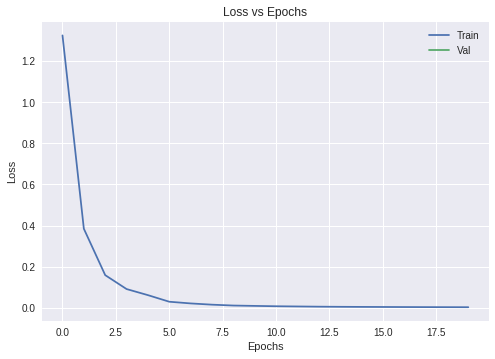

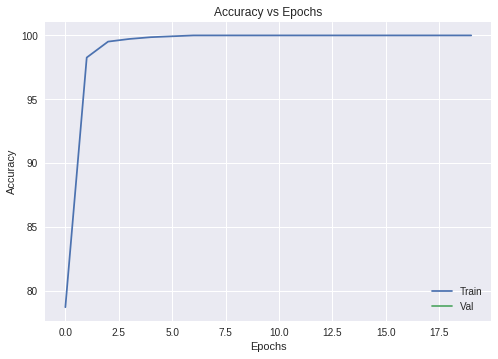

In [0]:
################################
# Model1 : 1 LSTM + 1 FC
################################

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

# sequence classification model1
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.recurrent_layer = torch.nn.LSTM(4096,100, num_layers = 1, dropout=0.5, batch_first=True)
        self.classify_layer = nn.Linear(100, 15)
    
    def forward(self, input, h_t_1=None, c_t_1=None):
        rnn_outputs, (hn, cn) = self.recurrent_layer(input)
        logits = self.classify_layer(rnn_outputs[:,-1])
        return logits
      
model1 = Model1()

optimizer = torch.optim.Adam(model1.parameters(), amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

num_epochs = 20
evaluate_every_epoch = 1
train_loss=[]
val_loss=[]
train_acc=[]
val_acc=[]
for e in range(num_epochs):
    accuracy, loss_val = run_epoch(train_loader, model1, criterion, e, True, optimizer)
    train_acc.append(accuracy)
    train_loss.append(loss_val)
         
plot_acc_loss(train_acc, val_acc, train_loss, val_loss)



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


train Epoch: 0  , Loss: 0.7718,  Accuracy: 77.95
train Epoch: 1  , Loss: 0.2804,  Accuracy: 91.40
train Epoch: 2  , Loss: 0.1019,  Accuracy: 97.02
train Epoch: 3  , Loss: 0.1286,  Accuracy: 95.91
train Epoch: 4  , Loss: 0.1061,  Accuracy: 97.02
train Epoch: 5  , Loss: 0.0329,  Accuracy: 99.24
train Epoch: 6  , Loss: 0.0130,  Accuracy: 99.65
train Epoch: 7  , Loss: 0.0535,  Accuracy: 98.54
train Epoch: 8  , Loss: 0.0506,  Accuracy: 98.40
train Epoch: 9  , Loss: 0.0127,  Accuracy: 99.79
train Epoch: 10  , Loss: 0.0036,  Accuracy: 99.86
train Epoch: 11  , Loss: 0.0007,  Accuracy: 100.00
train Epoch: 12  , Loss: 0.0005,  Accuracy: 100.00
train Epoch: 13  , Loss: 0.0003,  Accuracy: 100.00
train Epoch: 14  , Loss: 0.0003,  Accuracy: 100.00
train Epoch: 15  , Loss: 0.0002,  Accuracy: 100.00
train Epoch: 16  , Loss: 0.0002,  Accuracy: 100.00
train Epoch: 17  , Loss: 0.0002,  Accuracy: 100.00
train Epoch: 18  , Loss: 0.0002,  Accuracy: 100.00
train Epoch: 19  , Loss: 0.0001,  Accuracy: 100.00


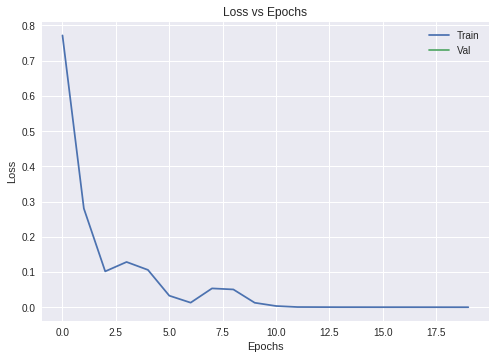

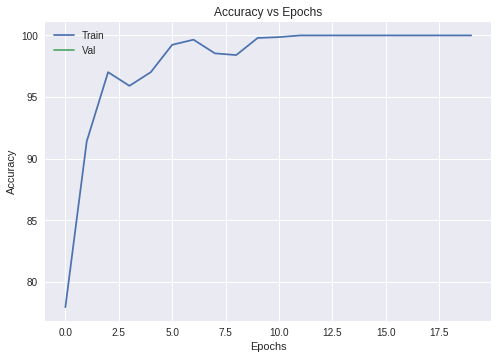

In [123]:
################################
# Model2 : 2 LSTM + 1 FC
################################

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

# sequence classification model2
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.recurrent_layer_1 = torch.nn.LSTM(4096, 1024, num_layers=1, batch_first = True)
        self.recurrent_layer_2 = torch.nn.LSTM(1024, 512, num_layers=1, batch_first = True)
        self.dropout = nn.Dropout(p=0.2)
        self.project_layer_1 = torch.nn.Linear(512, 128)
        self.project_layer_2 = torch.nn.Linear(128, 15)

    def forward(self, input, h_t_1=None, c_t_1=None):
        rnn_outputs, (hn, cn) = self.recurrent_layer_1(input)
        rnn_outputs = self.dropout(rnn_outputs)
        rnn_outputs, (hn, cn) = self.recurrent_layer_2(rnn_outputs)
        rnn_outputs = self.dropout(rnn_outputs)        
        logits = self.project_layer_1(rnn_outputs[:,-1])
        rnn_outputs = self.dropout(logits)
        logits = self.project_layer_2(rnn_outputs)
        return logits
      
model2 = Model2()

optimizer = torch.optim.Adam(model2.parameters(), amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

num_epochs = 20
evaluate_every_epoch = 1
train_loss=[]
val_loss=[]
train_acc=[]
val_acc=[]
for e in range(num_epochs):
    accuracy, loss_val = run_epoch(train_loader, model2, criterion, e, True, optimizer)
    train_acc.append(accuracy)
    train_loss.append(loss_val)
         
plot_acc_loss(train_acc, val_acc, train_loss, val_loss)




/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


train Epoch: 0  , Loss: 1.6339,  Accuracy: 65.12
train Epoch: 1  , Loss: 0.3331,  Accuracy: 97.30
train Epoch: 2  , Loss: 0.0814,  Accuracy: 99.72
train Epoch: 3  , Loss: 0.0317,  Accuracy: 99.86
train Epoch: 4  , Loss: 0.0145,  Accuracy: 100.00
train Epoch: 5  , Loss: 0.0093,  Accuracy: 100.00
train Epoch: 6  , Loss: 0.0071,  Accuracy: 100.00
train Epoch: 7  , Loss: 0.0052,  Accuracy: 100.00
train Epoch: 8  , Loss: 0.0042,  Accuracy: 100.00
train Epoch: 9  , Loss: 0.0035,  Accuracy: 100.00


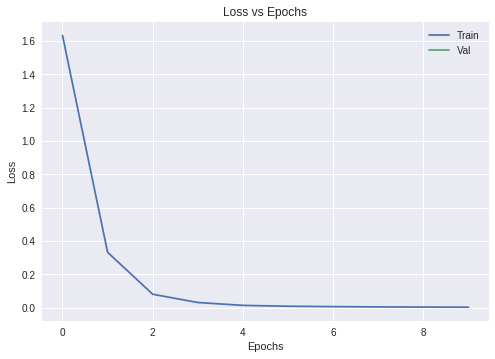

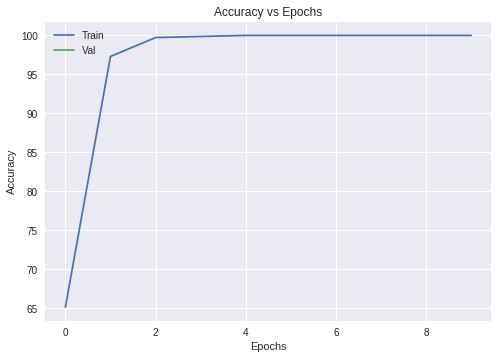

In [0]:
################################
# Model3 : LSTM + CNN
################################

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

# sequence classification model3
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.recurrent_layer = torch.nn.LSTM(4096,100, num_layers = 1, dropout=0.5, batch_first=True)
        self.classify_layer = torch.nn.Sequential(
            torch.nn.Conv1d(25,4,3),
            torch.nn.BatchNorm1d(4),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            Flatten(),
            torch.nn.Linear(392,15))
    
    def forward(self, input, h_t_1=None, c_t_1=None):
        rnn_outputs, (hn, cn) = self.recurrent_layer(input)
        logits = self.classify_layer(rnn_outputs)
        return logits
      
model3 = Model3()

optimizer = torch.optim.Adam(model3.parameters(), amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

gpu_dtype = torch.cuda.FloatTensor

num_epochs = 10
evaluate_every_epoch = 1
train_loss=[]
val_loss=[]
train_acc=[]
val_acc=[]
for e in range(num_epochs):
    accuracy, loss_val = run_epoch(train_loader, model3, criterion, e, True, optimizer)
    train_acc.append(accuracy)
    train_loss.append(loss_val)
         
plot_acc_loss(train_acc, val_acc, train_loss, val_loss)



In [9]:
################################
# Model4 : SVM
################################
xtrain = cPickle.load(open('../UCF101_release/xtrain.p','rb'))
ytrain = cPickle.load(open('../UCF101_release/ytrain.p','rb'))
xtest = cPickle.load(open('../UCF101_release/xtest.p','rb'))
ytest = cPickle.load(open('../UCF101_release/ytest.p','rb'))
gt = cPickle.load(open('../UCF101_release/ytest.p', 'rb'))

xtrain = xtrain.reshape((xtrain.shape[0], -1))
xtest = xtest.reshape((xtest.shape[0], -1))
print xtrain.shape
clf = LinearSVC(C=1.0)
clf.fit(xtrain, ytrain)
res4 = clf.predict(xtest)
print "Accuracy (Model4 : SVM): ", np.sum(gt==res4)*100.0/len(gt)

 (1442, 102400)
Accuracy (Model4 : SVM):  95.77464788732394


In [0]:
cPickle.dump(model1, open('model1.p','wb'))
cPickle.dump(model2, open('model2.p','wb'))
cPickle.dump(model3, open('model3.p','wb'))
cPickle.dump(clf, open('svm_clf.p','wb'))

In [124]:
gt = cPickle.load(open('../UCF101_release/ytest.p', 'rb'))

res1 = np.array(predict_on_test(model1, test_loader))
print "Accuracy (Model1 : LSTM ): ", np.sum(gt-1==res1)*100.0/len(gt)

res2 = np.array(predict_on_test(model2, test_loader))
print "Accuracy (Model2 : LSTM ): ", np.sum(gt-1==res2)*100.0/len(gt)

res3 = np.array(predict_on_test(model3, test_loader))
print "Accuracy (Model3 : LSTM + CNN ): ", np.sum(gt-1==res3)*100.0/len(gt)

res4 = clf.predict(xtest)
print "Accuracy (Model4 : SVM): ", np.sum(gt==res4)*100.0/len(gt)

Accuracy (Model1 : LSTM ):  95.4225352112676
Accuracy (Model2 : LSTM ):  94.19014084507042
Accuracy (Model3 : LSTM + CNN ):  94.36619718309859
Accuracy (Model4 : SVM):  95.77464788732394


## Submission
---
**Runnable source code in ipynb file and a pdf report are required**.

The report should be of 3 to 4 pages describing what you have done and learned in this homework and report performance of your model. If you have tried multiple methods, please compare your results. If you are using any external code, please cite it in your report. Note that this homework is designed to help you explore and get familiar with the techniques. The final grading will be largely based on your prediction accuracy and the different methods you tried (different architectures and parameters).

Please indicate clearly in your report what model you have tried, what techniques you applied to improve the performance and report their accuracies. The report should be concise and include the highlights of your efforts.